<a href="https://colab.research.google.com/github/GavinLi2/Gavin.github.io/blob/master/Main_Training_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# %load ML_diplay.py
"""
机器学习建模
"""
import pandas as pd
import numpy as np
import sys
import os
import lightgbm as lgb
from  datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import gc
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/1 - Walmart M5 Accuracy" 
os.chdir(path)

In [0]:
# def create_train_data(train_start=750,test_start=1800,is_train=True):
#     # 基本参数
#     PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
#     CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
#             "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
#             "month": "int8", "year": "int16", "snap_CA": "int8", 'snap_TX': 'int8', 'snap_WI': 'int8' }

#     start_day = train_start if is_train else test_start
#     numcols = [f"d_{day}" for day in range(start_day,1914)]
#     catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
#     SALE_DTYPES = {numcol: "float32" for numcol in numcols} 
#     SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

#     # 加载price数据
#     price_data = pd.read_csv('sell_prices.csv',dtype=PRICE_DTYPES)
#     # 加载cal数据
#     cal_data = pd.read_csv('calendar.csv',dtype=CAL_DTYPES)
#     # 加载sale数据
#     sale_data = pd.read_csv('sales_train_validation.csv',dtype=SALE_DTYPES,usecols=catcols+numcols)

#     # 根据季节和趋势强度对item进行分类
#     # score_strength = pd.read_csv('score_strength.csv')
#     # sale_data = pd.merge(sale_data,score_strength,on='id')
#     # sale_data['s'] = sale_data['s'].apply(lambda x: 1 if x < 0.95 else 0)
#     # sale_data['t'] = sale_data['t'].apply(lambda x: 1 if x < 0.88 else 0)
#     # sale_data[['s','t']] = sale_data[['s','t']].astype('int8')

#     # 获取每个item的权重
#     # weights = pd.read_csv('weights_validation.csv')
#     # weights = weights[weights['Level_id'] == 'Level12']
#     # weights['id'] = weights['Agg_Level_1'] + '_' + weights['Agg_Level_2'] + '_validation'
#     # sale_data = pd.merge(sale_data,weights[['id','Weight']],on='id')
#     # sale_data['Weight'] = sale_data['Weight'].astype('float32')

#     # 类别标签转换
#     # lgbm可以处理分类变量，无需one-hot编码，但是要将分类特征dtype转为int
#     for col, col_dtype in PRICE_DTYPES.items():
#         if col_dtype == "category":
#             price_data[col] = price_data[col].cat.codes.astype("int16") 
#             #↑cat方法将category转换为CategoricalAccessor对象，codes方法以Series返回该对象的所有类名及对应索引，用于将类标签转为数值
#             price_data[col] -= price_data[col].min() #令类标签从0开始

#     cal_data["date"] = pd.to_datetime(cal_data["date"])
#     cal_data, CAL_DTYPES = event_features(cal_data,CAL_DTYPES,3)
#     for col, col_dtype in CAL_DTYPES.items():
#         if col_dtype == "category":
#             cal_data[col] = cal_data[col].cat.codes.astype("int16")
#             cal_data[col] -= cal_data[col].min()

#     for col in catcols:
#         if col != "id":
#             sale_data[col] = sale_data[col].cat.codes.astype("int16")
#             sale_data[col] -= sale_data[col].min()

#     if not is_train:
#         for day in range(1913+1, 1913+ 2*28 +1):
#             sale_data[f"d_{day}"] = np.nan
#     # melt函数：将数据分为三部分：①id-like的列；②variables列：将指定列的列名，融合到一列中；③values列：将被融合的列的值，与融合后的列一一对应
#     sale_data = pd.melt(sale_data,
#             # id_vars = catcols + ['s','t','Weight'],
#             id_vars = catcols + ['s','t'],
#             value_vars = [col for col in sale_data.columns if col.startswith("d_")],
#             var_name = "d",
#             value_name = "sales")
#     sale_data = sale_data.merge(cal_data, on= "d", copy = False)
#     sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)

#     # 处理时间特征
#     # 有的时间特征没有，通过datetime的方法自动生成
#     date_features = {
#             "wday": "weekday",
#             "week": "weekofyear",
#             "month": "month",
#             "quarter": "quarter",
#             "year": "year",
#             "mday": "day",}

#     for date_feat_name, date_feat_func in date_features.items():
#         if date_feat_name in sale_data.columns:
#             pass
#         else:
#             sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")

#     sale_data.drop(["wm_yr_wk", "weekday"],axis=1,inplace=True)

#     return sale_data


# def create_feature(sale_data, is_train=True, day=None):
#     # 可以在这里加入更多的特征抽取方法
#     # 获取7天前的数据，28天前的数据
#     lags = [7, 28]
#     lag_cols = [f"lag_{lag}" for lag in lags ]

#     # 如果是测试集只需要计算一天的特征，减少计算量
#     # 注意训练集和测试集特征生成要一致
#     if is_train:
#         for lag, lag_col in zip(lags, lag_cols):
#             sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)
#     else:
#         for lag, lag_col in zip(lags, lag_cols):
#             sale_data.loc[sale_data.date == day, lag_col] = sale_data.loc[sale_data.date ==day-timedelta(days=lag), 'sales'].values
#             # day变量是指需要预测的日期。这里直接取需要预测的日期对应的lag的数据，而没有用shift函数，减小了计算量（不用冗余地处理非预测日期的数据）  


#     # 将获取7天前的数据，28天前的数据做移动平均
#     wins = [7, 28]

#     if is_train:
#         for win in wins :
#             for lag,lag_col in zip(lags, lag_cols):
#                 # sale_data = pd.concat([sale_data,
#                 #                   sale_data[['id', lag_col]].groupby('id')[lag_col].apply(lambda x: x.rolling(win).agg({
#                 #                                             f"rmean_{lag}_{win}":'mean',
#                 #                                             f"rmedian_{lag}_{win}":'median',
#                 #                                             f"rstd_{lag}_{win}":'std',
#                 #                                             f"rmax_{lag}_{win}":'max',
#                 #                                             f"rmin_{lag}_{win}":'min'}))], axis=1)
#                 sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype('float32')
#                 if lag == 28:
#                     sale_data[f"rmedian_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).median()).astype('float32')
#                     sale_data[f"rstd_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).std()).astype('float32')
#                     sale_data[f"rmax_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).max()).astype('float32')
#                 else:
#                     pass
#     else:
#         for win in wins:
#             for lag in lags:
#                 # 取lag天前，窗口大小为win的日期的数据【i.e.取两个时间节点间的数据】
#                 df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
#                 if lag == 28:
#                     # 将数据按id聚合
#                     df_window_grouped = df_window.groupby("id").agg({'sales':['mean','median','std','max']})
#                     df_window_grouped = df_window_grouped.reindex(sale_data.loc[sale_data.date==day,'id'])['sales']
#                     sale_data[[
#                             f"rmean_{lag}_{win}",
#                             f"rmedian_{lag}_{win}",
#                             f"rstd_{lag}_{win}",
#                             f"rmax_{lag}_{win}",
#                                       ]] = df_window_grouped.set_index(sale_data.loc[sale_data.date == day].index).astype('float32')
#                 else:
#                     df_window_grouped = df_window.groupby("id").agg({'sales':'mean'})
#                     df_window_grouped = df_window_grouped.reindex(sale_data.loc[sale_data.date==day,'id'])['sales']
#                     sale_data.loc[sale_data.date == day, f"rmean_{lag}_{win}"] = df_window_grouped.values

#     return sale_data

# def train_model(train_data,valid_data):
#     params = {"objective" : "tweedie",
#               "metric" :"rmse",
#               "force_row_wise" : True,
#               "learning_rate" : 0.075,
#               "sub_feature" : 0.8,
#               "sub_row" : 0.75,
#               "bagging_freq" : 1,
#               "lambda_l2" : 0.1,
#               "metric": ["rmse"],
#               "nthread": 8,
#               "tweedie_variance_power":1.2,
#               'verbosity': 1,
#               'num_iterations' : 1500,
#               'num_leaves': 128,
#               "min_data_in_leaf": 104,
#               }

#     m_lgb = lgb.train(params, train_data, valid_sets = [valid_data], verbose_eval=50)

#     return m_lgb


# def predict_ensemble(train_cols,m_lgb):
#     date = datetime(2016,4, 25) 
#     # 选择要乘以的系数
#     alphas = [1.035, 1.03, 1.025]
#     weights = [1/len(alphas)]*len(alphas)
#     sub = 0.

#     test_data = create_train_data(is_train=False)

#     for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

#         test_data_c = test_data.copy()
#         cols = [f"F{i}" for i in range(1,29)]


#         for i in range(0, 28):
#             day = date + timedelta(days=i)
#             print(i, day)
#             tst = test_data_c[(test_data_c.date >= day - timedelta(days=57)) & (test_data_c.date <= day)].copy()
#             tst = create_feature(tst,is_train=False, day=day)
#             tst = tst.loc[tst.date == day , train_cols]
#             test_data_c.loc[test_data_c.date == day, "sales"] = alpha*m_lgb.predict(tst)

#         # 改为提交数据的格式
#         test_sub = test_data_c.loc[test_data_c.date >= date, ["id", "sales"]].copy()
#         test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
#         test_sub = test_sub.set_index(["id", "F"]).unstack()["sales"][cols].reset_index()
#         test_sub.fillna(0., inplace = True)
#         test_sub.sort_values("id", inplace = True)
#         test_sub.reset_index(drop=True, inplace = True)
#         # test_sub.to_csv(f"submission_{icount}.csv",index=False)
#         if icount == 0 :
#             sub = test_sub
#             sub[cols] *= weight
#         else:
#             sub[cols] += test_sub[cols]*weight
#         print(icount, alpha, weight)
    
#     sub2 = sub.copy()
#     # 把大于28天后的validation替换成evaluation
#     sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
#     sub = pd.concat([sub, sub2], axis=0, sort=False)
#     sub.to_csv("submission_v10.csv",index=False)

In [0]:
def create_train_data(train_start=750,test_start=1800,is_train=True):
    # 基本参数
    PRICE_DTYPES = {"store_id": "category", "item_id": "category", "wm_yr_wk": "int16","sell_price":"float32" }
    CAL_DTYPES={"event_name_1": "category", "event_name_2": "category", "event_type_1": "category", 
            "event_type_2": "category", "weekday": "category", 'wm_yr_wk': 'int16', "wday": "int16",
            "month": "int8", "year": "int16", "snap_CA": "int8", 'snap_TX': 'int8', 'snap_WI': 'int8' }

    start_day = train_start if is_train else test_start
    numcols = [f"d_{day}" for day in range(start_day,1914)]
    catcols = ['id', 'item_id', 'dept_id','store_id', 'cat_id', 'state_id']
    SALE_DTYPES = {numcol: "float32" for numcol in numcols} 
    SALE_DTYPES.update({col: "category" for col in catcols if col != "id"})

    # 加载price数据
    price_data = pd.read_csv('sell_prices.csv',dtype=PRICE_DTYPES)
    # 加载cal数据
    cal_data = pd.read_csv('calendar.csv',dtype=CAL_DTYPES)
    # 加载sale数据
    sale_data = pd.read_csv('sales_train_validation.csv',dtype=SALE_DTYPES,usecols=catcols+numcols)

    # # 根据季节和趋势强度对item进行分类
    # score_strength = pd.read_csv('score_strength.csv')
    # sale_data = pd.merge(sale_data,score_strength,on='id')
    # sale_data['s'] = sale_data['s'].apply(lambda x: 1 if x < 0.95 else 0)
    # sale_data['t'] = sale_data['t'].apply(lambda x: 1 if x < 0.88 else 0)
    # sale_data[['s','t']] = sale_data[['s','t']].astype('int8')

    # 获取每个item的权重
    # weights = pd.read_csv('weights_validation.csv')
    # weights = weights[weights['Level_id'] == 'Level12']
    # weights['id'] = weights['Agg_Level_1'] + '_' + weights['Agg_Level_2'] + '_validation'
    # sale_data = pd.merge(sale_data,weights[['id','Weight']],on='id')
    # sale_data['Weight'] = sale_data['Weight'].astype('float32')

    # 类别标签转换
    for col, col_dtype in PRICE_DTYPES.items():
        if col_dtype == "category":
            price_data[col] = price_data[col].cat.codes.astype("int16") 
            #↑cat方法将category转换为CategoricalAccessor对象，codes方法以Series返回该对象的所有类名及对应索引，用于将类标签转为数值
            price_data[col] -= price_data[col].min() #令类标签从0开始

    cal_data["date"] = pd.to_datetime(cal_data["date"])
    cal_data, CAL_DTYPES = event_features(cal_data,CAL_DTYPES,3)
    for col, col_dtype in CAL_DTYPES.items():
        if col_dtype == "category":
            cal_data[col] = cal_data[col].cat.codes.astype("int16")
            cal_data[col] -= cal_data[col].min()

    for col in catcols:
        if col != "id":
            sale_data[col] = sale_data[col].cat.codes.astype("int16")
            sale_data[col] -= sale_data[col].min()

    if not is_train:
        for day in range(1913+1, 1913+ 2*28 +1):
            sale_data[f"d_{day}"] = np.nan
    # melt函数：将数据分为三部分：①id-like的列；②variables列：将指定列的列名，融合到一列中；③values列：将被融合的列的值，与融合后的列一一对应
    sale_data = pd.melt(sale_data,
            # id_vars = catcols + ['s','t','Weight'],
            id_vars = catcols,
            value_vars = [col for col in sale_data.columns if col.startswith("d_")],
            var_name = "d",
            value_name = "sales")
    sale_data = sale_data.merge(cal_data, on= "d", copy = False)
    sale_data = sale_data.merge(price_data, on = ["store_id", "item_id", "wm_yr_wk"], copy = False)

    # 处理时间特征
    # 有的时间特征没有，通过datetime的方法自动生成
    date_features = {
            "wday": "weekday",
            "week": "weekofyear",
            "month": "month",
            "quarter": "quarter",
            "year": "year",
            "mday": "day",}

    for date_feat_name, date_feat_func in date_features.items():
        if date_feat_name in sale_data.columns:
            pass
        else:
            sale_data[date_feat_name] = getattr(sale_data["date"].dt, date_feat_func).astype("int16")

    sale_data.drop(["wm_yr_wk", "weekday"],axis=1,inplace=True)

    return sale_data


def create_feature(sale_data, is_train=True, day=None):
    # 可以在这里加入更多的特征抽取方法
    # 获取7天前的数据，28天前的数据
    lags = [7, 28]
    lag_cols = [f"lag_{lag}" for lag in lags ]

    # 如果是测试集只需要计算一天的特征，减少计算量
    # 注意训练集和测试集特征生成要一致
    if is_train:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data[lag_col] = sale_data[["id","sales"]].groupby("id")["sales"].shift(lag)
    else:
        for lag, lag_col in zip(lags, lag_cols):
            sale_data.loc[sale_data.date == day, lag_col] = sale_data.loc[sale_data.date ==day-timedelta(days=lag), 'sales'].values
            # day变量是指需要预测的日期。这里直接取需要预测的日期对应的lag的数据，而没有用shift函数，减小了计算量（不用冗余地处理非预测日期的数据）  


    # 将获取7天前的数据，28天前的数据做移动平均
    wins = [7, 28]

    if is_train:
        for win in wins :
            for lag,lag_col in zip(lags, lag_cols):
                sale_data[f"rmean_{lag}_{win}"] = sale_data[["id", lag_col]].groupby("id")[lag_col].transform(lambda x : x.rolling(win).mean()).astype('float32')
    else:
        for win in wins:
            for lag in lags:
                # 取lag天前，窗口大小为win的日期的数据【i.e.取两个时间节点间的数据】
                df_window = sale_data[(sale_data.date <= day-timedelta(days=lag)) & (sale_data.date > day-timedelta(days=lag+win))]
                df_window_grouped = df_window.groupby("id").agg({'sales':'mean'}).reindex(sale_data.loc[sale_data.date==day,'id'])['sales']
                sale_data.loc[sale_data.date == day, f"rmean_{lag}_{win}"] = df_window_grouped.astype('float32').values
    return sale_data

def train_model(train_data,valid_data):
    params = {"objective" : "tweedie",
              "metric" :"rmse",
              "force_row_wise" : True,
              "learning_rate" : 0.075,
              "sub_feature" : 0.8,
              "sub_row" : 0.75,
              "bagging_freq" : 1,
              "lambda_l2" : 0.1,
              "nthread": 8,
              "tweedie_variance_power":1.2,
              'verbosity': 1,
              'num_iterations' : 1500,
              'num_leaves': 128,
              "min_data_in_leaf": 104,
              }

    m_lgb = lgb.train(params, train_data, valid_sets = [train_data, valid_data], verbose_eval=50)

    return m_lgb


def predict_ensemble(train_cols,m_lgb):
    date = datetime(2016,4,25) 
    # 选择要乘以的系数
    alphas = [1.035, 1.03, 1.025]
    weights = [1/len(alphas)]*len(alphas)
    sub = 0.

    test_data = create_train_data(is_train=False)

    for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

        test_data_c = test_data.copy()
        cols = [f"F{i}" for i in range(1,29)]


        for i in range(0, 28):
            day = date + timedelta(days=i)
            print(i, day)
            tst = test_data_c[(test_data_c.date >= day - timedelta(days=57)) & (test_data_c.date <= day)].copy()
            tst = create_feature(tst,is_train=False, day=day)
            tst = tst.loc[tst.date == day , train_cols]
            test_data_c.loc[test_data_c.date == day, "sales"] = alpha*m_lgb.predict(tst)

        # 改为提交数据的格式
        test_sub = test_data_c.loc[test_data_c.date >= date, ["id", "sales"]].copy()
        test_sub["F"] = [f"F{rank}" for rank in test_sub.groupby("id")["id"].cumcount()+1]
        test_sub = test_sub.set_index(["id", "F"]).unstack()["sales"][cols].reset_index()
        test_sub.fillna(0., inplace = True)
        test_sub.sort_values("id", inplace = True)
        test_sub.reset_index(drop=True, inplace = True)
        # test_sub.to_csv(f"submission_{icount}.csv",index=False)
        if icount == 0 :
            sub = test_sub
            sub[cols] *= weight
        else:
            sub[cols] += test_sub[cols]*weight
        print(icount, alpha, weight)
    
    sub2 = sub.copy()
    # 把大于28天后的validation替换成evaluation
    sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
    sub = pd.concat([sub, sub2], axis=0, sort=False)
    sub.to_csv("submission_v13.csv",index=False)

In [0]:
'''
构造节日特征：
日期前后三天有无节日？有几个节日？距离节日几天？
'''
def event_features(calendar,cal_dtypes,span):
  events_list = np.concatenate([calendar[calendar.event_name_1.notnull()].event_name_1.unique(),calendar[calendar.event_name_2.notnull()].event_name_2.unique()])

  # 抽取节日前n天的日期
  event_info_b = {}
  for event in events_list:
    event_date = calendar[(calendar.event_name_1 == event) | (calendar.event_name_2 == event)].date
    event_info_b[event] = sum([list(zip((event_date - timedelta(i)).to_list(),[i]*len(event_date))) for i in range(1,span+1)],[])
  days_before_events = {}
  for (event,info) in event_info_b.items():
    for date, i in info:
      if date not in days_before_events:
        days_before_events[date] = [(event,i)]
      else:
        days_before_events[date].append((event,i))

  # 抽取节日后n天的日期
  event_info_a = {}
  for event in events_list:
    event_date = calendar[(calendar.event_name_1 == event) | (calendar.event_name_2 == event)].date
    event_info_a[event] = sum([list(zip((event_date + timedelta(i)).to_list(),[i]*len(event_date))) for i in range(1,span+1)],[])
  days_after_events = {}
  for (event,info) in event_info_a.items():
    for date, i in info:
      if date not in days_after_events:
        days_after_events[date] = [(event,i)]
      else:
        days_after_events[date].append((event,i))
  
  calendar['before_events'] = calendar.date.apply(lambda x: tuple(days_before_events[x]) if x in days_before_events else np.nan)
  calendar['after_events'] = calendar.date.apply(lambda x: tuple(days_after_events[x]) if x in days_after_events else np.nan)
  calendar[['before_events','after_events']] = calendar[['before_events','after_events']].astype('category')

  cal_dtypes['before_events'], cal_dtypes['after_events'] = 'category', 'category'

  return calendar, cal_dtypes

In [0]:
# 辅助函数
# 1.内存优化
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col != 'sales':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min >= np.iinfo(np.uint8).min and c_max <= np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif c_min >= np.iinfo(np.uint16).min and c_max <= np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# 2.RMSSE评估
def evaluate(valid_sets):
    import pickle
    with open('/content/drive/My Drive/1 - Walmart M5 Accuracy/Evaluation/submission_index.pkl','rb') as f:
        submission_index = pickle.load(f)
    with open('/content/drive/My Drive/1 - Walmart M5 Accuracy/Evaluation/valid_id.pkl','rb') as f:
        valid_pred = pickle.load(f)
    with open('/content/drive/My Drive/1 - Walmart M5 Accuracy/Evaluation/evaluate.pkl','rb') as f:
        e = pickle.load(f)
    valid_pred['sales'] = m_lgb.predict(valid_sets)
    valid_pred = valid_pred.set_index(['id','d']).unstack()['sales']
    valid_pred = valid_pred.reindex(submission_index).values
    print('RMSSE: {:.6}'.format(e.score(valid_pred)))


In [0]:
if __name__ == '__main__':
    sale_data = create_train_data(train_start=600,is_train=True)
    sale_data = create_feature(sale_data)
    sale_data = reduce_mem_usage(sale_data)

    cat_feats = ['item_id', 'dept_id','store_id', 'cat_id', 'state_id'] + ["event_name_1", "event_type_1", "event_name_2", 'event_type_2'] + ['before_events','after_events']
    useless_cols = ["id", "date", "sales", "d", "Weight"]
    train_cols = sale_data.columns[~sale_data.columns.isin(useless_cols)]

    # valid set中有8个新品，存在nan值。为了便于后续WRMSSE计算，先提取验证集再清洗nan【lgb可以处理nan值】
    X_valid = sale_data.loc[(sale_data.date <= '2016-04-24') & (sale_data.date > '2016-03-27'),train_cols]
    y_valid = sale_data.loc[(sale_data.date <= '2016-04-24') & (sale_data.date > '2016-03-27'),'sales']
    # w_valid = sale_data.loc[(sale_data.date <= '2016-04-24') & (sale_data.date > '2016-03-27'),'Weight']

    # 清洗数据，选择需要训练的数据
    sale_data.dropna(inplace=True)

    # X_train = sale_data[train_cols]
    # y_train = sale_data["sales"]
    X_train = sale_data.loc[sale_data.date <= '2016-03-27',train_cols]
    y_train = sale_data.loc[sale_data.date <= '2016-03-27',"sales"]
    # w = sale_data.loc[sale_data.date <= '2016-03-27',"Weight"]
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feats, free_raw_data=True)

    valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_feats, reference=train_data, free_raw_data=True) 

    del sale_data
    gc.collect()

    m_lgb = train_model(train_data,valid_data)
    joblib.dump(m_lgb,'lgb_v13.pkl')

    # 实例化评估对象
    train_df = pd.read_csv('sales_train_validation.csv')
    cal_data = pd.read_csv('calendar.csv')
    price_data = pd.read_csv('sell_prices.csv')
    train_fold_df = train_df.iloc[:,:-28]
    valid_fold_df = train_df.iloc[:,-28:].copy()
    e = WRMSSEEvaluator(train_fold_df, valid_fold_df, cal_data, price_data)
    del train_fold_df, train_df, cal_data, price_data

    m_lgb.eval_valid(evaluate_wrmsse)

    predict_ensemble(train_cols,m_lgb)

In [0]:
e.score(valid_pred)

0.4291943513152775

In [0]:
0.4291943513152775
0.4250293989838226

In [0]:
FI_v8 = pd.DataFrame({'Features':m_lgb.feature_name(),'FI':m_lgb.feature_importance(),'Gain':m_lgb.feature_importance('gain')})
FI_v8.sort_values(by='Gain',ascending=False,inplace=True)

In [0]:
FI_v8

,Features,FI,Gain
25,rmean_7_28,4156,2.885735e+08
23,rmean_7_7,3545,7.977996e+07
0,item_id,77382,2.535571e+07
26,rmean_28_28,3954,1.302783e+07
15,before_events,36515,6.537572e+06
16,after_events,35999,6.084248e+06
21,lag_7,1835,3.737031e+06
5,wday,1025,2.773991e+06
24,rmean_28_7,2624,1.865526e+06
1,dept_id,1867,1.374570e+06


In [0]:
from sklearn.model_selection import train_test_split
X_train, _ = train_test_split(X_train, train_size=0.8, stratify=X_train[['item_id','store_id']], random_state=666)

In [0]:
y_train = y_train.loc[X_train.index]
w = w.loc[X_train.index]

In [0]:
sale_data.to_csv('processed_sales.csv',index=False)

In [0]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt

In [0]:
# 对汇总数据进行3阶指数平滑，用其参数作为单条序列的3阶EMA参数
agg_data = pd.read_csv('sales_train_validation.csv')
day_cols = [f'd_{day}' for day in range(1,1914)]
total_sales = np.sum(agg_data[day_cols],axis=0).values
del agg_data

ema_3 = ExponentialSmoothing(total_sales[-1200:],
                             trend='add',
                             damped=True,
                             seasonal='add',
                             seasonal_periods=7)
ema_3.fit(optimized=True,
          use_boxcox=False,
          use_brute=False)
ema_3.params
#  'smoothing_level': 0.32744779559422194
# 'smoothing_seasonal': 0.008832911581660425
# 'smoothing_slope': 0.025600714399262807
# 'damping_slope': 3.854211620190662e-05

In [0]:
def ema_3nd(series):
  start_time = datetime.now()
  ema = ExponentialSmoothing(series, trend='add', seasonal='add', damped=True, seasonal_periods=7).fit(optimized=True, use_brute=False)
  end_time = datetime.now()
  print(end_time - start_time)
  return ema.fittedvalues

In [0]:
trial = sale_data[(sale_data.id == 'HOBBIES_1_095_CA_1_validation') | (sale_data.id == 'FOODS_3_707_WI_3_validation')]

In [0]:
trial['ema_3nd'] = trial[['id','sales']].groupby('id')['sales'].transform(ema_3nd)

0:00:00.039097
0:00:00.037701


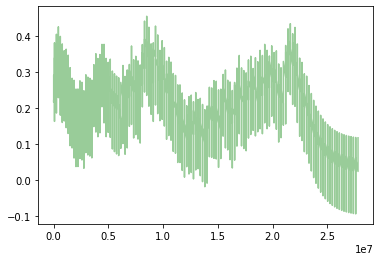

In [0]:
plt.plot(trial[trial.id == 'HOBBIES_1_095_CA_1_validation']['sales'])
plt.plot(trial[trial.id == 'HOBBIES_1_095_CA_1_validation']['ema_3nd'],color='green',alpha=0.4)
plt.plot(trial[trial.id == 'HOBBIES_1_095_CA_1_validation']['rmean_7_7'],color='red',alpha=0.7)

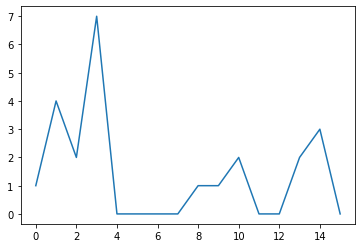

In [0]:
originial_sale_data = pd.read_csv('sales_train_validation.csv')
item1 = originial_sale_data[originial_sale_data.id == 'HOUSEHOLD_1_020_WI_2_validation'][[f'd_{i}' for i in range(1,1914)]].values[0][-44:-28]
plt.plot(item1)

In [0]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import unitroot_adf
from statsmodels.api import tsa

In [0]:
item1_dc = tsa.seasonal_decompose(item1,model='additive',freq=7,two_sided=True)

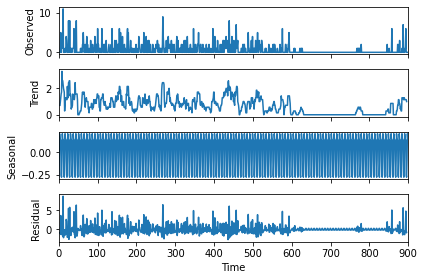

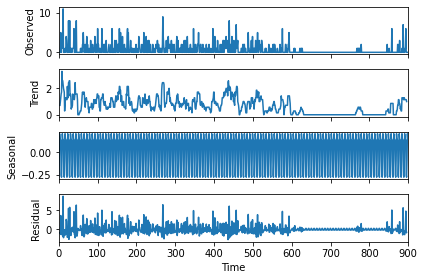

In [0]:
item1_dc

In [0]:
def components_strength(series):
    result = tsa.seasonal_decompose(series,model='additive',freq=7)
    seasonality = result.seasonal[~np.isnan(result.seasonal)][3:-3]
    trend = result.trend[~np.isnan(result.trend)]
    resid = result.resid[~np.isnan(result.resid)]
    score_s = max(0,resid.std() / (seasonality + resid).std())
    score_t = max(0,resid.std() / (trend + resid).std())
    return score_s,score_t

In [0]:
sales_cols = [f'd_{day}' for day in range(1000,1914)]
scoresList_s = []
scoresList_t = []
for item in originial_sale_data.id:
    score_s, score_t = components_strength(originial_sale_data[originial_sale_data.id == item][sales_cols].values[0])
    scoresList_s.append(score_s)
    scoresList_t.append(score_t)
score_df = pd.DataFrame({'s':scoresList_s,'t':scoresList_t})

In [0]:
score_df.describe()

,s,t
count,30490.000000,30490.000000
mean,0.984942,0.852120
std,0.023245,0.143794
min,0.000000,0.000000
25%,0.982755,0.817905
50%,0.991119,0.880997
75%,0.995050,0.913014
max,0.999858,15.037405


In [0]:
plot_acf(item1)

In [0]:
plot_acf(np.diff(item1))

In [0]:
unitroot_adf(item1)

(-3.2727157622769814,
 0.016143012300946773,
 19,
 880,
 {'1%': -3.4378028154245515,
  '10%': -2.568521809142562,
  '5%': -2.864829958032025},
 2938.477288686696)

In [0]:
from typing import Union
import numpy as np
import pandas as pd
from tqdm.auto import tqdm as tqdm

class WRMSSEEvaluator(object):
    
    group_ids = ( 'all_id', 'state_id', 'store_id', 'cat_id', 'dept_id', 'item_id',
        ['state_id', 'cat_id'],  ['state_id', 'dept_id'], ['store_id', 'cat_id'],
        ['store_id', 'dept_id'], ['item_id', 'state_id'], ['item_id', 'store_id'])

    def __init__(self, 
                 train_df: pd.DataFrame, 
                 valid_df: pd.DataFrame, 
                 calendar: pd.DataFrame, 
                 prices: pd.DataFrame):
        '''
        intialize and calculate weights
        '''
        self.calendar = calendar
        self.prices = prices
        self.train_df = train_df
        self.valid_df = valid_df
        self.train_target_columns = [i for i in self.train_df.columns if i.startswith('d_')]
        self.weight_columns = self.train_df.iloc[:, -28:].columns.tolist()

        self.train_df['all_id'] = "all"

        self.id_columns = [i for i in self.train_df.columns if not i.startswith('d_')]
        self.valid_target_columns = [i for i in self.valid_df.columns if i.startswith('d_')]

        if not all([c in self.valid_df.columns for c in self.id_columns]):
            self.valid_df = pd.concat([self.train_df[self.id_columns], self.valid_df],
                                      axis=1, 
                                      sort=False)
        self.train_series = self.trans_30490_to_42840(self.train_df, 
                                                      self.train_target_columns, 
                                                      self.group_ids)
        self.valid_series = self.trans_30490_to_42840(self.valid_df, 
                                                      self.valid_target_columns, 
                                                      self.group_ids)
        self.weights = self.get_weight_df()
        self.scale = self.get_scale()
        self.train_series = None
        self.train_df = None
        self.prices = None
        self.calendar = None

    def get_scale(self):
        '''
        scaling factor for each series ignoring starting zeros
        '''
        scales = []
        for i in tqdm(range(len(self.train_series))):
            series = self.train_series.iloc[i].values
            series = series[np.argmax(series!=0):]
            scale = ((series[1:] - series[:-1]) ** 2).mean()
            scales.append(scale)
        return np.array(scales)
    
    def get_name(self, i):
        '''
        convert a str or list of strings to unique string 
        used for naming each of 42840 series
        '''
        if type(i) == str or type(i) == int:
            return str(i)
        else:
            return "--".join(i)
    
    def get_weight_df(self) -> pd.DataFrame:
        """
        returns weights for each of 42840 series in a dataFrame
        """
        day_to_week = self.calendar.set_index("d")["wm_yr_wk"].to_dict()
        weight_df = self.train_df[["item_id", "store_id"] + self.weight_columns].set_index(
            ["item_id", "store_id"]
        )
        weight_df = (
            weight_df.stack().reset_index().rename(columns={"level_2": "d", 0: "value"})
        )
        weight_df["wm_yr_wk"] = weight_df["d"].map(day_to_week)
        weight_df = weight_df.merge(
            self.prices, how="left", on=["item_id", "store_id", "wm_yr_wk"]
        )
        weight_df["value"] = weight_df["value"] * weight_df["sell_price"]
        weight_df = weight_df.set_index(["item_id", "store_id", "d"]).unstack(level=2)[
            "value"
        ]
        weight_df = weight_df.loc[
            zip(self.train_df.item_id, self.train_df.store_id), :
        ].reset_index(drop=True)
        weight_df = pd.concat(
            [self.train_df[self.id_columns], weight_df], axis=1, sort=False
        )
        weights_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False)):
            lv_weight = weight_df.groupby(group_id)[self.weight_columns].sum().sum(axis=1)
            lv_weight = lv_weight / lv_weight.sum()
            for i in range(len(lv_weight)):
                weights_map[self.get_name(lv_weight.index[i])] = np.array(
                    [lv_weight.iloc[i]]
                )
        weights = pd.DataFrame(weights_map).T / len(self.group_ids)

        return weights

    def trans_30490_to_42840(self, df, cols, group_ids, dis=False):
        '''
        transform 30490 sries to all 42840 series
        '''
        series_map = {}
        for i, group_id in enumerate(tqdm(self.group_ids, leave=False, disable=dis)):
            tr = df.groupby(group_id)[cols].sum()
            for i in range(len(tr)):
                series_map[self.get_name(tr.index[i])] = tr.iloc[i].values
        return pd.DataFrame(series_map).T
    
    def get_rmsse(self, valid_preds) -> pd.Series:
        '''
        returns rmsse scores for all 42840 series
        '''
        score = ((self.valid_series - valid_preds) ** 2).mean(axis=1)
        rmsse = (score / self.scale).map(np.sqrt)
        return rmsse

    def score(self, valid_preds: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.valid_df[self.valid_target_columns].shape == valid_preds.shape

        if isinstance(valid_preds, np.ndarray):
            valid_preds = pd.DataFrame(valid_preds, columns=self.valid_target_columns)

        valid_preds = pd.concat([self.valid_df[self.id_columns], valid_preds],
                                axis=1, 
                                sort=False)
        valid_preds = self.trans_30490_to_42840(valid_preds, 
                                                self.valid_target_columns, 
                                                self.group_ids, 
                                                True)
        self.rmsse = self.get_rmsse(valid_preds)
        self.contributors = pd.concat([self.weights, self.rmsse], 
                                      axis=1, 
                                      sort=False).prod(axis=1)
        return np.sum(self.contributors)

In [0]:
train_df = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

In [0]:
train_fold_df = train_df.iloc[:, :-28]
valid_fold_df = train_df.iloc[:, -28:].copy()
e = WRMSSEEvaluator(train_fold_df, valid_fold_df, calendar, prices)

In [0]:
valid_preds = pd.read_csv('submission_v7.csv')
valid_preds = valid_preds.loc[:30489,[f'F{i}' for i in range(1,29)]]

In [0]:
valid_preds = np.random.randint(4, size=valid_fold_df.shape)

array([[0, 1, 3, ..., 3, 0, 1],
       [2, 1, 2, ..., 3, 1, 2],
       [3, 1, 0, ..., 1, 0, 1],
       ...,
       [1, 3, 0, ..., 3, 2, 1],
       [1, 3, 1, ..., 0, 1, 0],
       [3, 3, 0, ..., 3, 0, 1]])

In [0]:
e.score(valid_preds.values)

2.587377575691927